<a href="https://colab.research.google.com/github/Saumyanavani/sentence-embeddings/blob/main/Saumya_Navani_C4AIScholarsChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Friday September 29th at 12pm PDT.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

**Answer:** Dense sentence embeddings have extensive real-world applications due to their ability to retain and capture semantic information in a fixed-size vector. Some of these applications include: measuring semantic similarity between sentences and text classification like spam detection and sentiment analysis. They also play a vital role in translation, summarization, and question answering.

Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

**Answer:** There are multiple ways to compute sentence embeddings other than large language models. For example, Bag Of Words can compute embeddings by averaging a sentence's word vectors, and so can models like word2vec, and its extension - Doc2Vec, which extends embeddings from words to sentences or documents. Furthermore, RNN-based encoder-decoder models like Skip-Thoughts and Quick-Thoughts along with architectures like InferSent can compute sentence embeddings.

**Imports**

In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
# from transformers import AutoModel

## **Coding Challenge Part 1: Debugging custom BERT code [7 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 7 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 7 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
import torch
torch.manual_seed(0)

def gelu(x):
    """
    Gaussian Error Linear Unit (GELU) activation function.
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    """
    Configuration class for BERT model parameters.
    """
    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.1, #dropout probability was too high at 0.9, I set it to 0.1. Too high can lead to a significant drop in model performance.
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        """
        Method to allow instantiation from a dictionary.
        """
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      """
      Layer Normalization class which normalizes the activations of the neurons in a layer for each given sample in a batch independently.
      """
      def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        # Scale parameter
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        # Shift parameter
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        # A small float number to avoid any division by zero in the implementation
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        """
        Computes the layernorm as gamma * (x - mean(x)) / sqrt(var(x) + epsilon) + beta
        """
        # mean is now computed across the last dimension, ensuring proper normalization
        u = x.mean(-1, keepdim=True)
        # changed (x + u) to (x - u) to accurately compute the deviation from the mean for normalization
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class MLP(nn.Module):
      """
      Multi-Layer Perceptron (MLP) for processing the representation. It has two layers.
      """
      def __init__(self, hidden_size, intermediate_size):
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        """
        Performs forward pass with gelu activation in between the two linear layers.
        """
        x = gelu(self.dense_expansion(x))
        x = self.dense_contraction(x)
        return x


class Layer(nn.Module):
    """
    Transformer Layer class comprising one multi-head self-attention mechanism and one MLP.
    """
    def __init__(self, config):
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        """
        Reshapes the input tensor in such a way to split the last dimension into (num_heads, attention_head_size).
        This allows for parallel computation of self-attention heads.
        """
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """
        Reverts the operation performed in split_heads to get a single tensor.
        This merges the heads back to a single tensor.
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        """
        Implements the self-attention mechanism which is the core of transformer models.
        The attention scores are computed as a scaled dot-product of Q (query) and K (key),
        which are then used to weight the values (V) to produce the output of the attention layer.
        """
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        # transposed key vector correctly to ensure accurate attention score computation
        s = torch.matmul(q, k.transpose(-1,-2))
        s = s / math.sqrt(self.attention_head_size)
        # made sure to mask with large negative number
        s = torch.where(mask, s, torch.tensor(float('-inf')))

        # applied softmax to ensure the attention scores are probabilities that sum to 1
        p = F.softmax(s, dim=-1)
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        """
        Defines the forward pass of a single transformer layer.
        This includes passing the input through the self-attention mechanism,
        followed by a position-wise fully connected feed-forward network (MLP).
        """
        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)
        a = a + x # added input tensor to attention values to enable residual connection
        a = self.ln1(a)

        m = self.mlp(a)
        m = self.dropout(m)
        m = m + a # added multi layer attention output to attention values to enable residual connection
        m = self.ln2(m)

        return m


class Bert(nn.Module):
      """
      BERT Model class to instantiate the BERT model with specified configurations.
      """
      def __init__(self, config_dict):
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        """
        Defines the forward pass for the BERT model. It processes the input through embedding layers,
        multiple transformer layers, and finally through a pooler to get the output.
        """
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # Added instead of concatenating embeddings.
        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(token_type_ids)
        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-10-02 18:23:45--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-10-02 18:23:45--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin.3’

bert_tiny.bin.3     100%[===================>]  16.74M  --.-KB/s    in 0.1s    

2023-10-02 18:23:45 (162 MB/s) - ‘bert_tiny.bin.3’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
# bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

**Answer:** Pearson correlation measures the linear relationship between two continuous variables, indicating both the strength and direction of the linear relationship. On the other hand, Spearman correlation assesses the monotonic relationship between two variables, making it more robust to outliers and non-linear relationships. Evaluating using both metrics provides a comprehensive understanding of the relationship: while Pearson highlights linear trends, Spearman captures non-linear monotonic patterns.

In the context of sentence embeddings, Pearson correlation measures how well the linear relationship between the embeddings of two sentences aligns with human judgment scores. Spearman correlation, by examining the rank order, indicates how consistently the embeddings preserve the order of similarity or dissimilarity as judged by humans. By evaluating sentence embeddings with both metrics, we can ascertain not only how linearly the embeddings scale with human judgments but also whether they maintain the relative ordering of sentence similarities, which is crucial for many downstream tasks like document retrieval or semantic search.

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-02 18:23:51--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-02 18:23:51--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz.1’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   603KB/s    in 0.6s    

In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name):
  #TODO: add code to load STS dataset in required format
  sts_samples = {'test': []}
  df = pd.read_csv(file_name, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)
  df_test = df[df['split'] == 'test']

  for index, row in df_test.iterrows():
      sentence1 = row['sentence1']
      sentence2 = row['sentence2']
      score = row['score']
      sample = (sentence1, sentence2, score)
      sts_samples['test'].append(sample)
  return sts_samples


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
  #TODO: add code to generate tokenized version of the dataset
  tokenized_dataset = []
  for row in dataset:
    sentence1, sentence2, score = row
    tokens1 = tokenizer(sentence1, padding='max_length', max_length=max_length, return_tensors='pt')
    tokens2 = tokenizer(sentence2, padding='max_length', max_length=max_length, return_tensors='pt')
    tokenized_dataset.append((tokens1['input_ids'], tokens1['attention_mask'], tokens1['token_type_ids'], tokens2['input_ids'], tokens2['attention_mask'], tokens2['token_type_ids'], score))
  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):
  # TODO: Implement cosine similarity function **from scrach**:
  # This method should expect two 2D matrices (batch, vector_dim) and
  # return a 2D matrix (batch, batch) that contains all pairwise cosine similarities
  # return torch.zeros(a.shape[0], a.shape[0])
  norm_a = torch.nn.functional.normalize(a, p=2, dim=1)
  norm_b = torch.nn.functional.normalize(b, p=2, dim=1)
  return torch.mm(norm_a, norm_b.t())


def eval_loop(model, eval_dataloader, device):
  #TODO: add code to for evaluation loop
  #TODO: Use cosine_sim function above as distance metric for pearsonr and spearmanr functions that are imported
  model.to(device)
  model.eval()
  all_scores = []
  all_preds = []
  with torch.no_grad():
      for input_ids1, attention_masks1, _, input_ids2, attention_masks2, _, scores in eval_dataloader:
          all_scores.extend(scores)
          input_ids1, input_ids2 = input_ids1.squeeze(dim=1), input_ids2.squeeze(dim=1)
          input_ids1, input_ids2 = input_ids1.to(device), input_ids2.to(device)
          attention_masks1, attention_masks2 = attention_masks1.squeeze(dim=1), attention_masks2.squeeze(dim=1)
          attention_masks1, attention_masks2 = attention_masks1.to(device), attention_masks2.to(device)

          outputs1 = model(input_ids1, attention_mask=attention_masks1)
          outputs2 = model(input_ids2, attention_mask=attention_masks2)

          emb1 = outputs1[1]
          emb2 = outputs2[1]

          cos_s = cosine_sim(emb1, emb2).diagonal()
          all_preds.extend(cos_s.cpu().numpy())

  eval_pearson_cosine = pearsonr(all_scores, all_preds)[0]
  eval_spearman_cosine = spearmanr(all_scores,all_preds)[0]


  return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')
# bert = AutoModel.from_pretrained(MODEL_NAME)

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')


Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

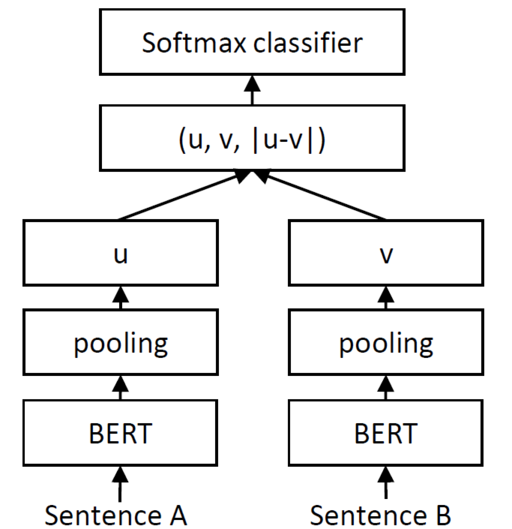

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method. Please follow the architecture illustrated in the given figure.

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-02 18:24:25--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 172.67.180.145, 104.21.67.200, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|172.67.180.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-02 18:24:26--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz.1’

AllNLI.tsv.gz.1     100%[===================>]  38.90M  12.4MB/s    in 3.1s    

2023-10-02 18:24:30 

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
#Custom function to convert labels to integers
def label2int(label):
  label_int = {"contradiction": 0, "entailment": 1, "neutral": 2}
  return label_int[label]

def contra_loss(embeddings1, embeddings2, temperature=0.05):
  """
  Computes the contrastive loss based on the cosine similarities between embeddings.
  This is similar to the SimCSE loss, aiming to maximize the similarity of positive pairs
  while minimizing the similarity of negative pairs.

  Args:
  - embeddings1 (Tensor): The embeddings for the first set of instances.
  - embeddings2 (Tensor): The embeddings for the second set of instances.
  - temperature (float): A scaling factor to normalize the similarities.

  Returns:
  - loss (Tensor): The computed contrastive loss.
  """
  # Calculate cosine similarities
  similarities = cosine_sim(embeddings1, embeddings2) / temperature

  # Extract diagonal elements which represent the positive pair similarities
  positive_similarities = torch.diag(similarities)

  # The loss is computed as the negative log likelihood of the positive pairs.
  # The `torch.logsumexp` function computes a stable log-sum-exp operation, which acts as a log-normalization factor.
  # This normalization factor ensures that the similarities are scaled properly, making the loss stable during training.
  loss = -positive_similarities + torch.logsumexp(similarities, dim=1)
  return loss.mean()

def load_nli_dataset(file_name):
  #TODO: add code to load NLI dataset in required format
  nli_samples = {'train': []}
  df = pd.read_csv(file_name, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)
  df_train = df[df['split'] == 'train']

  for index, row in df_train.iterrows():
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    label = row['label']
    label = label2int(label)
    sample = (sentence1, sentence2, label)
    nli_samples['train'].append(sample)
  return nli_samples


# A periodic eval on dev test can be added (validation_dataloader)
def train_loop(model, optimizer, train_dataloader, num_epochs, device):
    """
    This function encapsulates the training loop of the model.
    Args:
    - model (torch.nn.Module): The model to be trained.
    - optimizer (torch.optim.Optimizer): The optimizer to be used for training.
    - train_dataloader (torch.utils.data.DataLoader): The DataLoader for the training data.
    - num_epochs (int): The number of epochs to train for.
    - device (torch.device): The device (CPU/GPU) to be used for training.
    """
    model.to(device)

    # Instantiate the CrossEntropyLoss for computing loss (used for classification tasks) (no new imports added, only used nn)
    ce_loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            input_ids1, attention_mask1, token_type_ids1, input_ids2, attention_mask2, token_type_ids2, labels = [b.to(device) for b in batch]
            input_ids1, input_ids2 = input_ids1.squeeze(dim=1), input_ids2.squeeze(dim=1)

            attention_mask1, attention_mask2 = attention_mask1.squeeze(dim=1), attention_mask2.squeeze(dim=1)
            token_type_ids1, token_type_ids2 = token_type_ids1.squeeze(dim=1), token_type_ids2.squeeze(dim=1)

            # Check if the model is of type BertContrastive for specialized processing
            if isinstance(model, BertContrastive):
                embeddings1, embeddings2 = model(input_ids1, attention_mask1, token_type_ids1, input_ids2, attention_mask2, token_type_ids2)
                loss = contra_loss(embeddings1, embeddings2, temperature=0.05)
            else:
                outputs = model(input_ids1, attention_mask1, token_type_ids1, input_ids2, attention_mask2, token_type_ids2)
                loss = ce_loss(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}")

class BertClassifier(nn.Module):
    """
    Initializes the BertClassifier with a pre-trained BERT model with pooling, embedding concatenation, and softmax classifier.

    Args:
    - bert_model (nn.Module): The pre-trained BERT model.
    - num_labels (int): The number of classes for classification.
    """
    def __init__(self, bert_model, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.num_labels = num_labels

        # The softmax classifier consists of a linear layer followed by a softmax activation
        self.linear_classifier = nn.Linear(bert_model.config.hidden_size * 3, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids1, attention_mask1, token_type_ids1,
              input_ids2, attention_mask2, token_type_ids2):

        # Passing premise and hypothesis through the shared BERT encoder
        _, pooled_output1 = self.bert(input_ids=input_ids1, attention_mask=attention_mask1, token_type_ids=token_type_ids1)
        _, pooled_output2 = self.bert(input_ids=input_ids2, attention_mask=attention_mask2, token_type_ids=token_type_ids2)

        # Combining embeddings: [u, v, |u-v|]
        combined_output = torch.cat((pooled_output1, pooled_output2, torch.abs(pooled_output1 - pooled_output2)), dim=1)

        # Passing combined embeddings through the linear classifier
        logits = self.linear_classifier(combined_output)

        # Applying softmax to obtain class probabilities
        probabilities = self.softmax(logits)

        return logits

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

#TODO: Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert = Bert(bert_config).load_model('bert_tiny.bin')
bert_classifier = BertClassifier(bert, num_labels)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

Epoch 1/3 - Loss: 0.9101
Epoch 2/3 - Loss: 0.7709
Epoch 3/3 - Loss: 0.7038


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
# #TODO: run evaluation loop
model = bert_classifier.bert
result_from_classification = eval_loop(model, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.51
Spearman correlation: 0.54


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

In [ ]:
#TODO: add code to load NLI dataset in required format
###    if load_nli_dataset(..) is not appropriate for your method
def load_nli_dataset_for_contrastive(file_name):
    """
    Loads the Natural Language Inference (NLI) dataset in a format suitable for contrastive learning.

    Args:
    - file_name (str): The path to the dataset file.

    Returns:
    - nli_samples (dict): A dictionary containing training samples with pairs of sentences and labels.
    """
    nli_samples = {'train': []}
    df = pd.read_csv(file_name, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)
    df_train = df[df['split'] == 'train']

    for index, row in df_train.iterrows():
        sentence1 = row['sentence1']
        sentence2 = row['sentence2']
        label = row['label']

        # Map the textual labels to numerical values and append the samples to the training list
        # For contrastive purposes, the entailment is positive pair, and contradiction is the negative pair,
        # similar to Supervised SimCSE implementation: https://arxiv.org/abs/2104.08821 (for loss too)
        if label == 'entailment':
            nli_samples['train'].append((sentence1, sentence2, 1))
        elif label == 'contradiction':
            nli_samples['train'].append((sentence1, sentence2, 0))

    return nli_samples

class BertContrastive(nn.Module):
  """
  The BertContrastive class encapsulates a contrastive learning model based on a pre-trained BERT model,
  similar to the approach used in SimCSE. It processes pairs of sequences and generates embeddings for them,
  which can be used for contrastive loss computation.

  Similar to SimCSE, this model is designed to learn semantically meaningful embeddings for sentences by
  leveraging contrastive learning, where the objective is to minimize the distance between similar items
  (positive pairs) and maximize the distance between dissimilar items (negative pairs) in the embedding space.
  """
  def __init__(self, bert_model):
    super(BertContrastive, self).__init__()
    self.bert = bert_model

  def forward(self, input_ids1, attention_mask1, token_type_ids1,
              input_ids2, attention_mask2, token_type_ids2):
    _, embeddings1 = self.bert(input_ids=input_ids1, attention_mask=attention_mask1, token_type_ids=token_type_ids1)
    _, embeddings2 = self.bert(input_ids=input_ids2, attention_mask=attention_mask2, token_type_ids=token_type_ids2)

    return embeddings1, embeddings2


**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
# train_batch_size = 8
batch_size = 8
num_labels =3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset_for_contrastive('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)

#TODO: Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert = Bert(bert_config).load_model('bert_tiny.bin')
bert_contrastive = BertContrastive(bert)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

Epoch 1/3 - Loss: 1.7170
Epoch 2/3 - Loss: 1.6238
Epoch 3/3 - Loss: 1.5723


**Evaluation**

In [ ]:
#TODO: run evaluation loop
model = bert_contrastive.bert
result_from_contrastive = eval_loop(model, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')


Pearson correlation: 0.53
Spearman correlation: 0.56


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

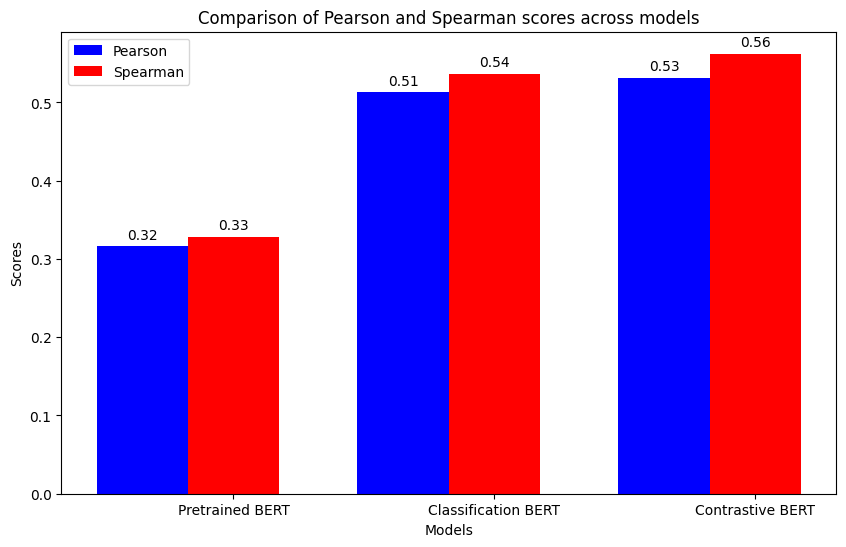

In [ ]:
import matplotlib.pyplot as plt

models = ['Pretrained BERT', 'Classification BERT', 'Contrastive BERT']
pearson_scores = [results_from_pretrained[0], result_from_classification[0], result_from_contrastive[0]]
spearman_scores = [results_from_pretrained[1], result_from_classification[1], result_from_contrastive[1]]

bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots(figsize=(10,6))
bar1 = ax.bar(index, pearson_scores, bar_width, label='Pearson', color='b')
bar2 = ax.bar([i+bar_width for i in index], spearman_scores, bar_width, label='Spearman', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Pearson and Spearman scores across models')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(models)
ax.legend()

def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

# plt.tight_layout()
plt.show()


# Differences and impact of different approaches
**1. Differences:**

1. ***Pretrained BERT:*** This model leverages vast amounts of data to understand language structures but hasn't been fine-tuned for the specific task of sentence similarity. It can provide a decent baseline but might not capture the nuances of semantic similarity as well as the other models. It does so by computing sentence embeddings for every sentence pair and computing the cosine_similarity for them.
2.  ***BERT Classifier (Softmax Classifier model):*** This model is fine-tuned on the NLI dataset, which means it has a more specific understanding of sentence relationships. It's trained to classify relationships into predefined classes, which can be limiting in capturing continuous semantic similarity. It understands (to an extent) the relationships between premise and hypothesis due to the fine-tuning on the NLI Dataset.
3. ***Contrastive BERT:*** This model is designed to differentiate between similar and dissimilar sentence pairs. The contrastive learning approach pushes similar sentences closer and dissimilar ones farther apart in the embedding space, which can be highly beneficial for a task like semantic textual similarity. Thus, this model understands sentence similarity and can group similar sentences together much better than the pretrained BERT (first implementation).

**2.Impact:**

1. ***Computational Efficiency:***

    a. *Pretrained BERT:* Fastest as no further training is required.
    
    b. *Classification BERT:* Requires fine-tuning, so there's additional computational overhead.

    c. *Contrastive BERT:* Depending on the approach, it might require more extensive training than the classification-based model.
2. ***Robustness:***

    a. *Pretrained BERT:* Might not be as robust for the specific task of STS.**Performed moderately well on the pearson and spearman correlations but was the worst out of three models.**
    
    b. *Classification BERT:* More robust than the pretrained model due to fine-tuning but can be limited by the nature of classification. Thus, **it can perform better than pretrained Bert on tasks like Semantic Textual Similarity**, getting much higher pearson and spearman scores.
    
    c. *Contrastive BERT:* Typically the most robust for tasks like STS as it's designed to understand similarities and differences between sentences. However, in this case, it performed similarly to the Classification based model, but still **had the highest Pearson and Spearman correlations.** This shows that it can understand sentence similarity well. With more fine-tuning and possibly different loss functions/hyperparameters, it could outperform the other two models by far.

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

I decided to use data augmentation, specifically backtranslation, to boost the contrastive learning process. Here's a concise breakdown of what I did:

**Backtranslation:** This involves translating a sentence from the source language to a target language and then translating it back to the source language. The result is a sentence that often keeps the original meaning but may have different phrasing or structure. This method effectively generates paraphrased or augmented data.

**Purpose of the Augmentation:** In the context of our task, backtranslation allowed me to create additional positive pairs (entailment pairs) for training. Given a sentence, its backtranslated version can be treated as a positive sample, essentially two variations of the same content. This augmented data is especially valuable for a contrastive learning task, where the objective is to pull positive pairs closer in the embedding space while pushing negative pairs apart.

**Impact:**

1. *Richer Training Data:* By using backtranslation, I exposed the model to diverse ways of phrasing similar content, aiming to make it more robust and adept at grasping nuances in sentence meanings.
2. *Enhanced Contrastive Learning:* The additional positive pairs from backtranslation provided the model with a broader set of examples, potentially leading to more meaningful and representative embeddings.
3. *Performance Boost:* I observed a decrease in training loss, indicating that the model was indeed benefiting from the augmented data.


In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Initialize MarianMT models for translation
en_to_de_model_name = 'Helsinki-NLP/opus-mt-en-de'
de_to_en_model_name = 'Helsinki-NLP/opus-mt-de-en'
en_to_de_tokenizer = MarianTokenizer.from_pretrained(en_to_de_model_name)
de_to_en_tokenizer = MarianTokenizer.from_pretrained(de_to_en_model_name)
en_to_de_model = MarianMTModel.from_pretrained(en_to_de_model_name).to(device)
de_to_en_model = MarianMTModel.from_pretrained(de_to_en_model_name).to(device)

def backtranslate(sentence):
    # Translate English to German
    german_tokens = en_to_de_tokenizer.encode(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    german_sentence = en_to_de_model.generate(german_tokens)[0]
    german_sentence = en_to_de_tokenizer.decode(german_sentence, skip_special_tokens=True)

    # Translate German back to English
    english_tokens = de_to_en_tokenizer.encode(german_sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    back_translated_sentence = de_to_en_model.generate(english_tokens)[0]
    return de_to_en_tokenizer.decode(back_translated_sentence, skip_special_tokens=True)


model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
# train_batch_size = 8
batch_size = 8
num_labels =3
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'
# Augment the NLI dataset
nli_samples = load_nli_dataset_for_contrastive('AllNLI.tsv.gz')

augmented_samples = []

# Augmenting a small portion for demonstration
for i, (sentence1, sentence2, label) in enumerate(nli_samples['train'][:100]):
    aug_sentence1 = backtranslate(sentence1)
    aug_sentence2 = backtranslate(sentence2)
    augmented_samples.append((aug_sentence1, aug_sentence2, label))

# Combine, tokenize, and train
combined_samples = nli_samples['train'][:5000] + augmented_samples
tokenized_train = tokenize_sentence_pair_dataset(combined_samples, tokenizer, max_length=128)
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

# Train the contrastive model
bert = Bert(bert_config).load_model('bert_tiny.bin')
bert_contrastive = BertContrastive(bert)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Epoch 1/3 - Loss: 1.2693
Epoch 2/3 - Loss: 0.9363
Epoch 3/3 - Loss: 0.7966


In [ ]:
model = bert_contrastive.bert
result_from_contrastive_augmented = eval_loop(model, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive_augmented[0]:.2f}\nSpearman correlation: {result_from_contrastive_augmented[1]:.2f}')


Pearson correlation: 0.58
Spearman correlation: 0.57


Plotting the Pearson and Spearman correlations for augmented data vs the normal Bert_contrastive model

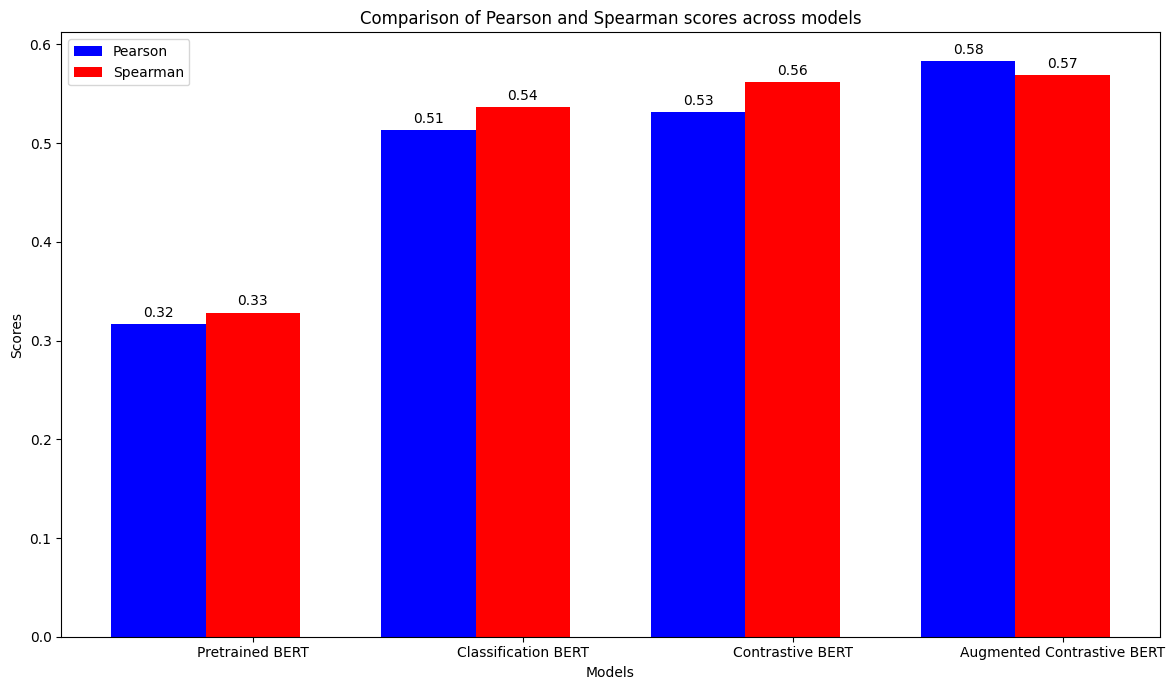

In [ ]:
import matplotlib.pyplot as plt

models = ['Pretrained BERT', 'Classification BERT', 'Contrastive BERT', 'Augmented Contrastive BERT']
pearson_scores = [results_from_pretrained[0], result_from_classification[0], result_from_contrastive[0], result_from_contrastive_augmented[0]]
spearman_scores = [results_from_pretrained[1], result_from_classification[1], result_from_contrastive[1], result_from_contrastive_augmented[1]]

bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots(figsize=(12,7))
bar1 = ax.bar(index, pearson_scores, bar_width, label='Pearson', color='b')
bar2 = ax.bar([i+bar_width for i in index], spearman_scores, bar_width, label='Spearman', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Pearson and Spearman scores across models')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(models)
ax.legend()

def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()

There wasn't much increase seen in the correlations, and this could be due to several factors. These factors could include:

1. *Complexity of Backtranslation:* Backtranslation might introduce noise or variations that aren't as effective for the task. The quality of backtranslation largely depends on the translation model used. Some backtranslated sentences might be too similar or too different from the original, affecting the contrastive learning process.

2. *Training Dynamics:* The number of epochs, learning rate, and other training parameters could impact the model's ability to leverage the augmented data. It's possible that with more epochs or a different learning rate, the model might benefit more from the augmented data.

3. *Limits on Augmented Data:* While the data has been augmented, only a 100 augmented examples have been added to the NLI dataset. It is very possible that with more augmented.

These are just some of the factors that could explain these results. But it is important to note that the model did show an improvement in performance on the STS dataset through backtranslation and data augmentation, however small that may be.